# Salary Predictions Based on Job Descriptions

# Step 3: Develop

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, './scripts')

from helpers import load_data, mean_squared_error
from Preprocessing import Preprocessing

In [3]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           5892        1899        2974         301        1018        3434
Swap:          2047          74        1973


### Engineering features
* Ensure data is ready for modeling (make Preprocessing.py)
* Create any new features to enhance the model

I wrote Preprocessing.py to do any transformations on the data to get it ready for the models __(note: include filtering columns in preprocessor)__.

In [4]:
path = './model_validation_data/'
files = ['train.csv', 'test.csv']

train_data = load_data(path, files[0], verbose=True)

----------------------------------train shape-----------------------------------
                                  (700000, 8)                                   
------------------------------train's column types------------------------------
salary                  int64
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object
-----------------------------train first five rows------------------------------
                  salary companyId  jobType       degree      major industry  \
jobId                                                                          
JOB1362684437508      72     COMP7  JANITOR         NONE       NONE   HEALTH   
JOB1362685136064     110    COMP32  MANAGER  HIGH_SCHOOL       NONE  FINANCE   
JOB1362684910878     132     COMP7      CFO  HIGH_SCHOOL       NONE      OIL   
JOB1362684976240      

In [5]:
target = 'salary'
features = [x for x in train_data.columns if x != target]

train_features = train_data[features].copy()
train_salary = train_data[target].copy()
del train_data

In [6]:
cols_to_filter = ['companyId']

p = Preprocessing(cols_to_filter=cols_to_filter)

features_transformed = p.fit_transform(train_features)

In [7]:
features_transformed.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
jobId,,,,,,,,,,,,,,,,,,,,,
JOB1362684437508,0.708333,0.474747,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
JOB1362685136064,0.250000,0.121212,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
JOB1362684910878,0.208333,0.909091,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
JOB1362684976240,0.291667,0.797980,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
JOB1362685230529,0.541667,0.181818,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
features_transformed.shape

(700000, 31)

In [9]:
import gc
gc.collect()

49

In [10]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           5892        2096        2734         301        1060        3237
Swap:          2047          74        1973


### Creating models
* Creating and tuning models (SGD Regressor, Random Forest Regressor, Nearest Neighbor)

I'm going to start with tuning the __K-Nearest Neighbor (KNN)__ model. I need to figure out what the best option for 'k' will be as well as how I would like to weight these neighbors when doing the calculation. For instance, it may be fruitful to make sure instances which are far away are not as prevalent as instances which are closer. Another option I will test is treating all k-nearest instances the the same.

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split


def tune_parameters_KNN(X, y, k, weights='distance'):
    """Finds the MSE of Nearest Neighbor Regression on a varying number of nearest neigbors
    Args:
        X: DataFrame, Feature data
        y: Series, Target data
        k: list of ints, number of neighbors to make the regression
        weights: string, tells the model how to weight the neighbors when calculating the regression
        
    Returns:
        error: ndarray, holds MSE betweenthe predicted salary and the actual salary
    """
    X_train, X_tune, y_train, y_tune = train_test_split(X, y, random_state=44, test_size=.25)
    
    error = np.zeros(len(k))
    
    for i, n_neighbors in enumerate(k):
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, n_jobs=-1)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_tune)
        error[i] = mean_squared_error(y_pred, y_tune)
        
        del knn
        
        print(f"Number of Neighbors: {n_neighbors}")
        print(f"Error: {error[i]}")
    
    return error
        

In [16]:
k_dis = [x for x in range(2, 11, 2)]

# Distance weighting of neighbors error
dis_error = tune_parameters_KNN(features_transformed, train_salary, k)

Number of Neighbors: 2
Error: 571.6184963156958
Number of Neighbors: 4
Error: 502.4679588755955
Number of Neighbors: 6
Error: 477.6507862760483
Number of Neighbors: 8
Error: 464.60752218291907
Number of Neighbors: 10
Error: 456.7079946327381


In [19]:
k_uw = [x for x in range(6, 21, 2)]

# Uniform weighting of neighbors error
uw_error = tune_parameters_KNN(features_transformed, train_salary, k_uw, weights='uniform')

Number of Neighbors: 6
Error: 417.3229846031746
Number of Neighbors: 8
Error: 402.45752464285715
Number of Neighbors: 10
Error: 394.0170414285714
Number of Neighbors: 12
Error: 388.4885171825397
Number of Neighbors: 14
Error: 384.4900773469387
Number of Neighbors: 16
Error: 381.81769357142855
Number of Neighbors: 18
Error: 379.65877705467375
Number of Neighbors: 20
Error: 378.32896221428575


In [24]:
k_uw_2 = [x for x in range(22, 31, 2)]

# Uniform weighting of neighbors error
uw_error_2 = tune_parameters_KNN(features_transformed, train_salary, k_uw_2, weights='uniform')

Number of Neighbors: 22
Error: 377.309125218418
Number of Neighbors: 24
Error: 376.58834697420633
Number of Neighbors: 26
Error: 375.97465844463227
Number of Neighbors: 28
Error: 375.7355246501458
Number of Neighbors: 30
Error: 375.5971672126984


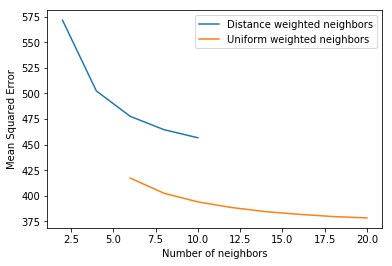

In [22]:
k_dis = [x for x in range(2, 11, 2)]
k_uw = [x for x in range(6, 21, 2)]

plt.plot(k_dis, dis_error, label='Distance weighted neighbors')
plt.plot(k_uw, uw_error, label='Uniform weighted neighbors')
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Squared Error')
plt.legend()

Now, I'll start tuning for the __Random Forest (RF)__ regression model. I'll tune the *max_depth*, *max_features*, and *min_samples_leaf* features seperately with a smaller number of estimators. Then I will give a fine tune with a grid search of hyperparameter values closer to the best values for the small number of estimators. Note that I will be using oob score as a kind of cross validation when building the forest to quantify the accuracy of each model. This cross validation will output the average $R^2$ score on the data not used in each estimator. The higher the oob score, the better the parameters are for the model. 

In [11]:
# baseline model so we know how much better changing the hyperparameters makes the model
from sklearn.ensemble import RandomForestRegressor

# All of these parameters will remain the same when I change the hyperparameters
rf = RandomForestRegressor(oob_score=True, random_state=44, n_estimators=50, criterion='mse')

rf.fit(features_transformed, train_salary)
print(f"Baseline Accuracy: {rf.oob_score_}")

Baseline Accuracy: 0.6956883365746303


Maximum depth: 1
Score: 0.19471618400414492
Maximum depth: 5
Score: 0.5206619470860774
Maximum depth: 10
Score: 0.6852411290175356
Maximum depth: 15
Score: 0.7419815735343134
Maximum depth: 16
Score: 0.7452164873036183
Maximum depth: 17
Score: 0.7462248530995752
Maximum depth: 18
Score: 0.7450382927497465
Maximum depth: 19
Score: 0.7420751337854656
Maximum depth: 20
Score: 0.737814084520567
Maximum depth: 25
Score: 0.7106673805199004


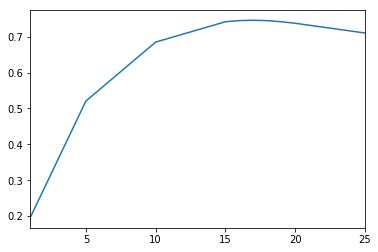

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

max_depths = [1, 5, 10, 15, 16, 17, 18, 19, 20, 25]

scores = np.zeros(len(max_depths))
    
for i, max_depth in enumerate(max_depths):
    rf = RandomForestRegressor(max_depth=max_depth, n_estimators=50,
                                min_samples_leaf=1, max_features='auto',
                                oob_score=True, n_jobs=-1, random_state=44,
                                criterion='mse'
                              )
        
    rf.fit(features_transformed, train_salary)
        
    scores[i] = rf.oob_score_
    del rf
    
    print(f"Maximum depth: {max_depth}")
    print(f"Score: {scores[i]}")

pd.Series(scores, index=max_depths).plot()

In [26]:
results = pd.Series(scores, index=max_depths)

print(f"Maximum Accuracy occurs when max_depth is set to {results.idxmax()}")

Maximum Accuracy occurs when max_depth is set to 17


Note: I don't have enough computing power to show that this trend does continue, but it is highly unlikely to ever go back up due to overfitting.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

min_samples_leaf = [8, 9, 10, 15, 20, 25, 30, 35]
leaf_scores_mse = np.zeros(len(min_samples_leaf))

for i, sample in enumerate(min_samples_leaf):

    rf = RandomForestRegressor(n_estimators=50, criterion='mse',
                               min_samples_leaf=sample, max_features='auto',
                               oob_score=True, n_jobs=-1, random_state=44
                              )
    rf.fit(features_transformed, train_salary)
    
    leaf_scores_mse[i] = rf.oob_score_
    del rf
    
    print(f"Samples: {sample}")
    print(f"Oob score: {leaf_scores_mse[i]}")

Samples: 8
Oob score: 0.7473800758878565
Samples: 9
Oob score: 0.7485985644433109
Samples: 10
Oob score: 0.7494918259266532
Samples: 15
Oob score: 0.751912859131219
Samples: 20
Oob score: 0.7526958439832085
Samples: 25
Oob score: 0.7528428518084355
Samples: 30
Oob score: 0.7525993930074464
Samples: 35
Oob score: 0.7522223114928789


The maximum accuracy occurs when min_samples_leaf is set to 25


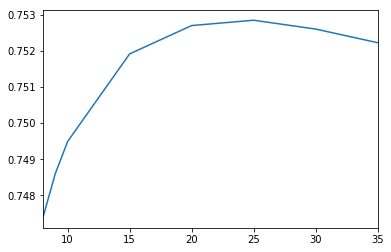

In [32]:
leaf_result_mse = pd.Series(leaf_scores_mse, index=min_samples_leaf)
print("The maximum accuracy occurs when min_samples_leaf is"
      f" set to {leaf_result_mse.idxmax()}"
     )

leaf_result_mse.plot()

In [12]:
from sklearn.ensemble import RandomForestRegressor

max_features = ['auto', 'sqrt', 'log2', None, .1, .2, .3, .4, .5, .6, .7, .8, .9]
max_features_score_mse = np.zeros(len(max_features))

for i, max_feature in enumerate(max_features):

    rf = RandomForestRegressor(n_estimators=50,criterion='mse',
                               min_samples_leaf=1, max_features=max_feature,
                               oob_score=True, n_jobs=-1, random_state=44
                              )
    rf.fit(features_transformed, train_salary)
    
    max_features_score_mse[i] = rf.oob_score_
    del rf
    
    print(f"Method: {max_feature}")
    print(f"Oob score: {max_features_score_mse[i]}")

Method: auto
Oob score: 0.6956883365746303
Method: sqrt
Oob score: 0.6900848567252967
Method: log2
Oob score: 0.6896142719125476
Method: None
Oob score: 0.6956883365746303
Method: 0.1
Oob score: 0.6889495218409942
Method: 0.2
Oob score: 0.6907517319998396
Method: 0.3
Oob score: 0.6924156643854461
Method: 0.4
Oob score: 0.6941909107499129
Method: 0.5
Oob score: 0.6950505845332222
Method: 0.6
Oob score: 0.6958451872253962
Method: 0.7
Oob score: 0.6963451560663227
Method: 0.8
Oob score: 0.6962607023710454
Method: 0.9
Oob score: 0.6964087432739166


The maximum accuracy occurs when max_features is set to 0.9


Text(0.5, 1.0, 'Maximum Features Allowed Accuracies')

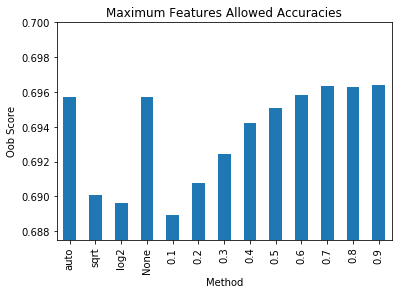

In [20]:
max_features_result_mse = pd.Series(max_features_score_mse, index=max_features)
print("The maximum accuracy occurs when max_features is"
      f" set to {max_features_result_mse.idxmax()}"
     )
ax = max_features_result_mse.plot.bar(ylim=(.6875,.7))
ax.set_xlabel('Method')
ax.set_ylabel('Oob Score')
ax.set_title('Maximum Features Allowed Accuracies')

In [11]:
from sklearn.ensemble import RandomForestRegressor
n_estimators = [5, 10, 15, 25, 35, 50, 75]

estimator_scores = np.zeros(len(n_estimators))

for i, n in enumerate(n_estimators):
    rf = RandomForestRegressor(n_estimators=n, criterion='mse',
                                min_samples_leaf=1, max_features='auto',
                                oob_score=True, n_jobs=-1, random_state=44
                               )
    
    rf.fit(features_transformed, train_salary)
    estimator_scores[i] = rf.oob_score_
    
    del rf
    print(f"Number of estimators: {n}")
    print(f"Oob score: {estimator_scores[i]}")

/home/kyle/DSDJ/Module4/salary-predictions/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of estimators: 5
Oob score: -0.3771210380993235


/home/kyle/DSDJ/Module4/salary-predictions/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of estimators: 10
Oob score: 0.5458731025204315


/home/kyle/DSDJ/Module4/salary-predictions/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of estimators: 15
Oob score: 0.6567710652836943


/home/kyle/DSDJ/Module4/salary-predictions/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of estimators: 25
Oob score: 0.6838828431076451
Number of estimators: 35
Oob score: 0.6908381117375268
Number of estimators: 50
Oob score: 0.6956883365746303
Number of estimators: 75
Oob score: 0.6993088615389236


The maximum accuracy occurs when n_estimators is set to 75


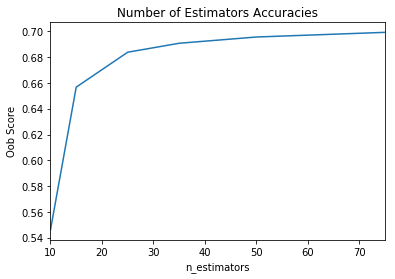

In [14]:
n_estimators_result = pd.Series(estimator_scores, index=n_estimators)

ax = n_estimators_result.iloc[1:].plot()
ax.set_xlabel('n_estimators')
ax.set_ylabel('Oob Score')
ax.set_title('Number of Estimators Accuracies')

print("The maximum accuracy occurs when n_estimators is"
      f" set to {n_estimators_result.idxmax()}"
     )

In a perfect world where I had unlimited computing power and infinite time, I would tune keep increasing n_estimators for as long as my patience would allow (probably around n_estimators=10000) to squeeze out that last thousandth of a percent out of the model. But, I have neither time nor computing power on my hand, so I will be using n_estimators=35 and forgo the extra couple of percentage points of accuracy increasing the estimators will create. This will allow my model to still have a high accuracy while also not limiting my time to actually train the models. 

In the future, I want to try tuning n_estimators first. Then I will tune the remaining hyperparameters using the n_estimators value at which accuracy begins to plateau. This will allow the tuning process to run quicker instead of taking up almost an entire day. After the rest of the hyperparameters are tuned, then I can increase the number of estimators for the final model with no adverse affects.

I will now begin tuning the __Stochastic Gradient Descent (SGD)__ regression model.

### ---- 9 Test models ----
* Doing a 5-fold cross validation on models and measuring MSE

### ---- 10 Select best model  ----
* Selecting the model with the lowest error as the "production" model